In [22]:
import numpy as np
import pandas as pd
from faker import Faker
from scipy.stats import skewnorm, beta, norm

# Severity distribution according to GEMA 5.0 guidelines
GEMA_SEVERITY_DIST = {
    "Intermittent": 0.25,
    "Mild Persistent": 0.35,
    "Moderate Persistent": 0.25,
    "Severe Persistent": 0.15
}

PERIOD = 24 * 365  # One year of hourly data

# Adherence parameters aligned with Symbicort guidelines
SYMBICORT_ADHERENCE_PARAMS = {
    "Intermittent": (2.0, 2.0),
    "Mild Persistent": (2.2, 1.8),
    "Moderate Persistent": (1.8, 2.2),
    "Severe Persistent": (1.5, 2.5)
}

# District configuration with geographic parameters
DISTRICT_CONFIG = {
    'Sant Marti': {'center': (41.3984, 2.1901), 'work_prob': 0.6, 'radius': 0.015},
    'Sants-Montjuic': {'center': (41.3601, 2.1331), 'work_prob': 0.4, 'radius': 0.02},
    'Eixample': {'center': (41.3954, 2.1611), 'work_prob': 0.7, 'radius': 0.01},
    'Gracia': {'center': (41.4024, 2.1553), 'work_prob': 0.3, 'radius': 0.008},
    'Ciutat Vella': {'center': (41.3805, 2.1733), 'work_prob': 0.5, 'radius': 0.006},
    'Horta-Guinardo': {'center': (41.4302, 2.1600), 'work_prob': 0.2, 'radius': 0.025},
    'Les Corts': {'center': (41.3853, 2.1315), 'work_prob': 0.5, 'radius': 0.018}
}

# Load and preprocess pollution data
POLLUTION_DATA = pd.read_parquet('../data/processed/air_quality/air_quality.parquet').drop(columns=['Estacio', 'Longitud', 'Latitud'])
POLLUTION_DATA['timestamp'] = pd.to_datetime(POLLUTION_DATA['timestamp'])

# Create complete datetime index for 2024
full_date_range = pd.date_range(start='2024-01-01', end='2024-12-31 23:00:00', freq='h')
district_list = list(DISTRICT_CONFIG.keys())

# Create complete pollution dataframe
pollution_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [full_date_range, district_list],
        names=['timestamp', 'Nom_districte']
    )
).reset_index()

# Merge and clean pollution data
pollution_df = pd.merge(pollution_df, POLLUTION_DATA, on=['timestamp', 'Nom_districte'], how='left')
pollution_df = pollution_df.sort_values(['Nom_districte', 'timestamp'])
pollution_df[['NO2 (µg/m³)', 'O3 (µg/m³)', 'PM2.5 (µg/m³)']] = pollution_df.groupby('Nom_districte')[
    ['NO2 (µg/m³)', 'O3 (µg/m³)', 'PM2.5 (µg/m³)']
].transform(lambda x: x.ffill().bfill().fillna(x.mean()))

def generate_realistic_location(home_district, work_district, num_hours):
    """Generate realistic movement patterns with district tracking"""
    home = DISTRICT_CONFIG[home_district]
    work = DISTRICT_CONFIG[work_district]
    districts, lats, lons = [], [], []
    
    current_district = home_district
    current_center = home['center']
    
    for hour in range(num_hours):
        day_type = 'weekday' if (hour // 24) % 7 < 5 else 'weekend'
        hour_of_day = hour % 24
        
        # Night time pattern (10pm-6am)
        if 22 <= hour_of_day or hour_of_day < 6:
            current_district = home_district
            current_center = home['center']
        
        # Weekday pattern
        elif day_type == 'weekday':
            if 6 <= hour_of_day < 9:
                current_center = (
                    (home['center'][0] + work['center'][0])/2,
                    (home['center'][1] + work['center'][1])/2
                )
                current_district = min(DISTRICT_CONFIG.keys(), 
                                     key=lambda d: np.linalg.norm(
                                         np.array(DISTRICT_CONFIG[d]['center']) - 
                                         np.array(current_center)))
            
            elif 9 <= hour_of_day < 18:
                current_district = work_district
                current_center = work['center']
            
            elif 18 <= hour_of_day < 20:
                current_center = (
                    (home['center'][0] + work['center'][0])/2,
                    (home['center'][1] + work['center'][1])/2
                )
                current_district = min(DISTRICT_CONFIG.keys(), 
                                     key=lambda d: np.linalg.norm(
                                         np.array(DISTRICT_CONFIG[d]['center']) - 
                                         np.array(current_center)))
            
            else:
                current_district = np.random.choice(
                    ['Gracia', 'Eixample', home_district],
                    p=[0.4, 0.4, 0.2]
                )
                current_center = DISTRICT_CONFIG[current_district]['center']
        
        # Weekend pattern
        else:
            if 10 <= hour_of_day < 18:
                current_district = np.random.choice(
                    [home_district, 'Ciutat Vella', 'Sants-Montjuic'],
                    p=[0.4, 0.4, 0.2]
                )
                current_center = DISTRICT_CONFIG[current_district]['center']
            else:
                current_district = home_district
                current_center = home['center']
        
        new_lat = np.random.normal(current_center[0], 0.001)
        new_lon = np.random.normal(current_center[1], 0.001)
        
        districts.append(current_district)
        lats.append(new_lat)
        lons.append(new_lon)
    
    return lats, lons, districts

def generate_gema_cohort(num_patients=50):
    fake = Faker('es_ES')
    np.random.seed(7)
    
    # Generate demographic data
    ages = np.clip(skewnorm.rvs(4, 45, 15, num_patients).astype(int), 12, 85)
    districts = list(DISTRICT_CONFIG.keys())
    
    patients = pd.DataFrame({
        "patient_id": [f"PAT-{i:04d}" for i in range(num_patients)],
        "gender": np.random.choice(["M", "F"], num_patients, p=[0.48, 0.52]),
        "age": ages,
        "home_district": np.random.choice(districts, num_patients, p=[0.18, 0.15, 0.22, 0.12, 0.10, 0.13, 0.10]),
        "gema_severity": np.random.choice(list(GEMA_SEVERITY_DIST.keys()), num_patients, p=list(GEMA_SEVERITY_DIST.values()))
    })
    
    # Assign work districts
    patients["work_district"] = patients["home_district"].apply(
        lambda hd: np.random.choice([hd] + [d for d in districts if d != hd],
        p=np.append(DISTRICT_CONFIG[hd]['work_prob'],
                    [(1-DISTRICT_CONFIG[hd]['work_prob'])/(len(districts)-1)]*(len(districts)-1))))
    
    # Calculate adherence
    def _get_adherence(severity_group):
        a, b = SYMBICORT_ADHERENCE_PARAMS[severity_group.name]
        return np.clip(np.random.beta(a, b, len(severity_group)), 0.4, 0.95)
    
    patients["symbicort_adherence"] = patients.groupby("gema_severity")["gema_severity"].transform(_get_adherence)
    
    # Generate inhale events
    inhaler_dfs = []
    for severity, group in patients.groupby("gema_severity"):
        params = {
            "Intermittent": (2.5, 0.5),
            "Mild Persistent": (5.0, 0.8),
            "Moderate Persistent": (9.0, 1.2),
            "Severe Persistent": (13.0, 1.8)
        }[severity]
        
        for _, patient in group.iterrows():
            lats, lons, districts = generate_realistic_location(
                patient['home_district'],
                patient['work_district'],
                PERIOD
            )
            
            timestamps = pd.date_range("2024-01-01", periods=PERIOD, freq='h')
            
            # Obtain pollution data
            no2_values, o3_values, pm25_values = [], [], []
            for ts, district in zip(timestamps, districts):
                try:
                    vals = pollution_df[
                        (pollution_df['Nom_districte'] == district) & 
                        (pollution_df['timestamp'] == ts)
                    ].iloc[0]
                except IndexError:
                    vals = pollution_df[pollution_df['Nom_districte'] == district].mean()
                
                no2_values.append(vals['NO2 (µg/m³)'])
                o3_values.append(vals['O3 (µg/m³)'])
                pm25_values.append(vals['PM2.5 (µg/m³)'])
            
            # Organic puff distribution logic
            daily_puffs = np.random.poisson(params[0] * patient["symbicort_adherence"], 365)
            daily_puffs = np.clip(daily_puffs, 0, 20)
            
            puffs = []
            hours = np.arange(24)
            
            for day_puffs in daily_puffs:
                daily = np.zeros(24)
                severity_group = patient["gema_severity"]
                max_hourly = 6 if day_puffs > 12 else 3
                
                # Circadian Rhythm Patterns
                if severity_group != "Intermittent":
                    # Individual chronotype
                    chrono_offset = np.random.choice([-2, -1, 0, 1, 2])
                    morning_peak = 8 + chrono_offset + np.random.normal(0, 1.5)
                    evening_peak = 20 - (chrono_offset * 0.7) + np.random.normal(0, 2)
                    
                    # Maintenance distribution
                    maintenance_prob = (
                        norm.pdf(hours, morning_peak, 2.0) + 
                        norm.pdf(hours, evening_peak, 2.5)
                    )
                    
                    # Normalize probabilities and handle zero sum
                    prob_sum = maintenance_prob.sum()
                    if prob_sum > 0:
                        maintenance_prob = maintenance_prob / prob_sum
                    else:
                        maintenance_prob = np.ones(24)/24  # Fallback uniform distribution
                    
                    maintenance_puffs = min(day_puffs, np.random.randint(4,7))
                    maintenance_dist = np.random.multinomial(
                        maintenance_puffs, 
                        np.clip(maintenance_prob, 0, 1)
                    )
                    daily += maintenance_dist
                
                # Activity-based Relief Pattern
                relief_prob = np.array([
                    # 00-04 (5 hours)
                    0.02, 0.01, 0.01, 0.01, 0.01,
                    # 05-08 (4 hours)
                    0.03, 0.05, 0.07, 0.1,
                    # 09-12 (4 hours)
                    0.15, 0.18, 0.2, 0.22,
                    # 13-16 (4 hours)
                    0.25, 0.27, 0.3, 0.28,
                    # 17-20 (4 hours)
                    0.25, 0.22, 0.2, 0.15,
                    # 21-23 (3 hours)
                    0.1, 0.05, 0.03  # Removed last 0.02 to make 24 elements total
                ])
                
                # Environmental modulation
                pm25 = np.mean(pm25_values[-24:]) if pm25_values else 10
                relief_prob *= np.where(
                    (hours >= 9) & (hours <= 19),
                    1 + (pm25 / 40),
                    1 - (pm25 / 100)
                )
                
                # Distribute remaining puffs
                remaining = day_puffs - np.sum(daily)
                last_puff = None
                while remaining > 0:
                    # Temporal clustering
                    if last_puff is not None and np.random.rand() < 0.6:
                        cluster_window = range(
                            max(0, last_puff - 2), 
                            min(24, last_puff + 3)
                        )
                        cluster_prob = relief_prob.copy()
                        cluster_prob[cluster_window] *= 2.0
                    else:
                        cluster_prob = relief_prob
                    
                    hour = np.random.choice(24, p=cluster_prob/cluster_prob.sum())
                    
                    if daily[hour] < max_hourly:
                        daily[hour] += 1
                        remaining -= 1
                        last_puff = hour
                
                puffs.extend(daily)
            
            inhaler_dfs.append(pd.DataFrame({
                "patient_id": patient["patient_id"],
                "timestamp": timestamps,
                "puffs": puffs,
                "latitude": lats,
                "longitude": lons,
                "district": districts,
                "NO2": no2_values,
                "O3": o3_values,
                "PM2.5": pm25_values
            }))
    
    inhaler_events = pd.concat(inhaler_dfs, ignore_index=True)
    
    # Calculate hospitalization flags
    inhaler_events['24h_puffs'] = inhaler_events.groupby('patient_id')['puffs'].transform(
        lambda x: x.rolling(24, min_periods=12).sum().fillna(0)
    )
    
    # Clinical risk model
    conditions = (
        (inhaler_events['24h_puffs'] > 12) |
        ((inhaler_events['PM2.5'] > 15) & (inhaler_events['24h_puffs'] > 8)) |
        ((inhaler_events['NO2'] > 25) & (inhaler_events['24h_puffs'] > 8))
    )
    inhaler_events['hospitalization_flag'] = np.where(conditions, 1, 0)
    
    # Ensure 3% hospitalization rate
    target = int(0.03 * len(inhaler_events))
    candidates = inhaler_events[inhaler_events['24h_puffs'] > 8].index
    if len(candidates) > target:
        flags = np.random.choice(candidates, target, replace=False)
        inhaler_events['hospitalization_flag'] = 0
        inhaler_events.loc[flags, 'hospitalization_flag'] = 1
    
    return patients, inhaler_events

# Generate and display data
patients, inhaler_events = generate_gema_cohort(50)
inhaler_events["date"] = inhaler_events["timestamp"].dt.date
inhaler_events = inhaler_events[['patient_id', 'timestamp', 'date', 'puffs', 
                                'latitude', 'longitude', 'district',
                                'NO2', 'O3', 'PM2.5', 'hospitalization_flag']]

# Analysis
daily_puffs = inhaler_events.groupby(['patient_id', 'date'])['puffs'].sum().reset_index()
hourly_dist = inhaler_events.groupby(inhaler_events['timestamp'].dt.hour)['puffs'].mean()

print(f"Generated patients: {len(patients)}")
print(f"Inhaler records: {len(inhaler_events):,}")
print(f"Daily puff average: {daily_puffs['puffs'].mean():.1f}")
print(f"Hospitalization rate: {inhaler_events['hospitalization_flag'].mean()*100:.1f}%")
print("\nHourly distribution:")
print(hourly_dist.apply(lambda x: f"{x:.3f}").to_string())

Generated patients: 50
Inhaler records: 438,000
Daily puff average: 3.5
Hospitalization rate: 3.0%

Hourly distribution:
timestamp
0     0.008
1     0.013
2     0.026
3     0.050
4     0.080
5     0.118
6     0.162
7     0.201
8     0.218
9     0.226
10    0.209
11    0.173
12    0.146
13    0.136
14    0.138
15    0.154
16    0.161
17    0.182
18    0.202
19    0.218
20    0.192
21    0.184
22    0.155
23    0.122


<Axes: xlabel='timestamp'>

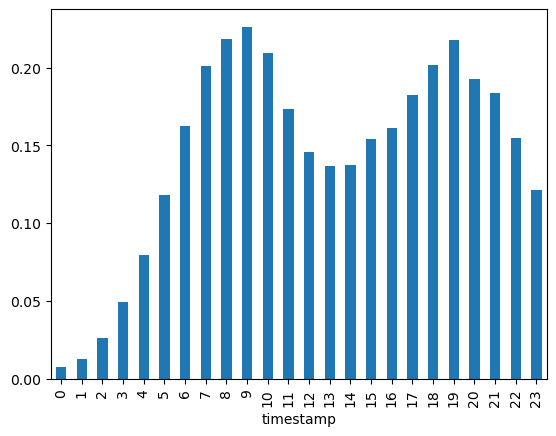

In [23]:
hourly_puffs = inhaler_events.groupby(inhaler_events['timestamp'].dt.hour)['puffs'].mean()
hourly_puffs.plot(kind='bar')

<Axes: xlabel='puffs'>

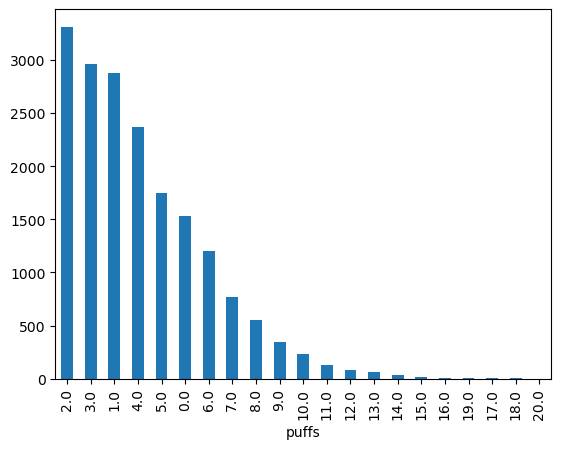

In [24]:
daily_puffs['puffs'].value_counts().plot(kind='bar')

In [25]:
# Save to Parquet with partitioning
inhaler_events.to_parquet(
    "../data/raw/iot_inhaler/inhaler_events.parquet",
    partition_cols=["date"],
    compression='snappy'
)

patients.to_parquet(
    "../data/raw/iot_inhaler/patients.parquet",
    compression='snappy'
)

In [26]:
def clinical_validation(patients_df):
    # 1. Define strict categorical order
    gema_order = [
        "Intermittent", 
        "Mild Persistent", 
        "Moderate Persistent", 
        "Severe Persistent"
    ]
    
    patients_df["gema_severity"] = pd.Categorical(
        patients_df["gema_severity"],
        categories=gema_order,
        ordered=True
    )
    
    # 2. Get distribution while maintaining original order
    severity_counts = patients_df["gema_severity"].value_counts(normalize=True, sort=False)
    
    # 3. Ordered comparison with adjusted tolerance
    expected_dist = np.array(list(GEMA_SEVERITY_DIST.values()))
    obtained_dist = severity_counts.values
    
    assert np.allclose(
        obtained_dist,
        expected_dist,
        atol=0.035,  # Tolerance for N=1000
        rtol=0.05    # Additional relative tolerance
    ), f"""Distribution out of expected range:
    Expected: {dict(zip(gema_order, expected_dist))}
    Actual: {dict(zip(gema_order, obtained_dist))}"""
    
    # Remaining validations...
    print("✓ Validation successful")

clinical_validation(patients)

✓ Validation successful


In [27]:
import folium
import pandas as pd

df_patients = inhaler_events[inhaler_events['patient_id'] == 'PAT-0004'][:(24*10)]

# Create base map centered on Barcelona
barcelona_coords = [41.3851, 2.1734]
patient_map = folium.Map(location=barcelona_coords, zoom_start=13)

# Add markers for each patient
for idx, row in df_patients.iterrows():
    popup_text = f"""
    Patient ID: {row['patient_id']}<br>
    Time: {row['timestamp']}<br>
    Puffs: {row['puffs']}<br>
    District: {row['district']}
    """
    puffs = row['puffs']
    color = 'green' if puffs < 1 else 'blue' if puffs <= 2 else 'orange' if puffs <= 5 else 'red'
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(color=color, icon='user-md', prefix='fa')
    ).add_to(patient_map)

patient_map